In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0" 
import ktrain
from ktrain import vision as vis

Using TensorFlow backend.


In [2]:
DATADIR = 'data/planet'
ORIGINAL_DATA = DATADIR+'/train_v2.csv'
CONVERTED_DATA = DATADIR+'/train_v2-CONVERTED.csv'
labels = vis.preprocess_csv(ORIGINAL_DATA, 
                           CONVERTED_DATA, 
                           x_col='image_name', y_col='tags', suffix='.jpg')

In [3]:
trn, val, preproc = vis.images_from_csv(
                          CONVERTED_DATA,
                         'image_name',
                          directory=DATADIR+'/train-jpg',
                          val_filepath = None,
                          label_columns = labels,
                          data_aug=vis.get_data_aug(horizontal_flip=True, vertical_flip=True))

Found 40479 images belonging to 1 classes.
Found 36357 validated image filenames.
Found 4122 validated image filenames.


In [5]:
model = vis.image_classifier('pretrained_resnet50', trn, val_data=val)
learner = ktrain.get_learner(model, train_data=trn, val_data=val, 
                             batch_size=64, workers=8, use_multiprocessing=False)
learner.freeze(2)

The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? True
pretrained_resnet50 model created.


simulating training for different learning rates... this may take a few moments...
568
5
2840
Epoch 1/5
568/568 [==============================] - 213s 375ms/step - loss: 0.6386 - acc: 0.7609
Epoch 2/5
568/568 [==============================] - 201s 353ms/step - loss: 0.2260 - acc: 0.9303
Epoch 3/5
380/568 [===================>..........] - ETA: 1:05 - loss: 0.3707 - acc: 0.9044

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


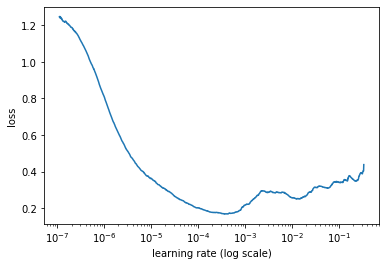

In [6]:
learner.lr_find()
learner.lr_plot()

In [9]:
learner.fit_onecycle(1e-4, 20)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/20
568/568 [==============================] - 206s 363ms/step - loss: 0.1980 - acc: 0.9299 - val_loss: 0.6752 - val_acc: 0.6485
Epoch 2/20
568/568 [==============================] - 206s 363ms/step - loss: 0.1426 - acc: 0.9492 - val_loss: 0.1381 - val_acc: 0.9508
Epoch 3/20
568/568 [==============================] - 206s 362ms/step - loss: 0.1248 - acc: 0.9547 - val_loss: 0.1074 - val_acc: 0.9616
Epoch 4/20
568/568 [==============================] - 206s 363ms/step - loss: 0.1159 - acc: 0.9577 - val_loss: 0.0996 - val_acc: 0.9637
Epoch 5/20
568/568 [==============================] - 207s 364ms/step - loss: 0.1090 - acc: 0.9601 - val_loss: 0.0977 - val_acc: 0.9643
Epoch 6/20
568/568 [==============================] - 206s 363ms/step - loss: 0.1054 - acc: 0.9609 - val_loss: 0.0987 - val_acc: 0.9629
Epoch 7/20
568/568 [==============================] - 206s 362ms/step - loss: 0.1038 - acc: 0.9616 - val_loss: 0.1052 - 

In [10]:
from sklearn.metrics import fbeta_score
import numpy as np
import warnings
def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

In [15]:
y_pred = learner.model.predict_generator(val)
y_true = val.labels

In [16]:
f2(y_pred, y_true)

0.9249264279306654